<a href="https://colab.research.google.com/github/soutrik71/pytorch_classics/blob/main/AP_Torch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is all about discussion on torch Workflow along with an comprehensive study on a Regression Model and a Classification Model.

In [1]:
# !pip install torchview

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from torchview import draw_graph

## Torch Workflow fundamentals using a MNIST dataset -- to setup the premise

```md
| Topic                                                    | Contents                                                                                                                          |
|----------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------|
| 1. Getting data ready                                    | Data can be almost anything but to get started we're going to create a simple straight line                                       |
| 2. Building a model                                      | Here we'll create a model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop.  |
| 3. Fitting the model to data (training)                  | We've got data and a model, now let's let the model (try to) find patterns in the (training) data.                                |
| 4. Making predictions and evaluating a model (inference) | Our model's found patterns in the data, let's compare its findings to the actual (testing) data.                                  |
| 5. Saving and loading a model                            | You may want to use your model elsewhere, or come back to it later, here we'll cover that.                                        |
|                                                          |                                                                                                                                   |

```

##### Key Pointers:
1. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
2. We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading.
3. nn.Module contains the larger building blocks (layers)
4. nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
5. forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
6. torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

##### Data Loading

In [3]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

In [4]:
# downloading the training data from Datasets library
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [5]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
batch_size = 128
epochs = 10
lr = 1e-3

In [7]:
print(training_data.data.shape)
print(test_data.data.shape)
print(training_data.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])


In [8]:
# wrapping the raw data into dataloader class
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [9]:
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


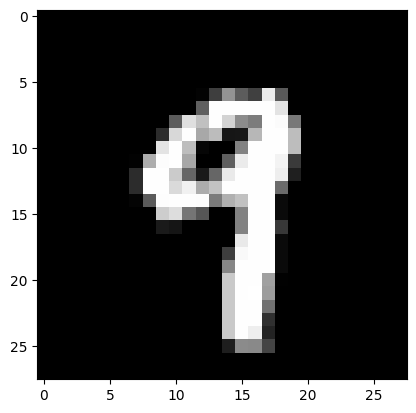

Label: 9


In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze() # Torch.Size([28, 28])
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

##### Model Definition Piece

In [42]:
class SimpleNN(nn.Module):
  """Simple NN model"""
  def __init__(self, input_size, num_classes):
    super(SimpleNN, self).__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(input_size, 50)
    self.fc2 = nn.Linear(50, num_classes)

  def forward(self, x: torch.Tensor):
    x = self.flatten(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

In [43]:
# declaring the model
model = SimpleNN(input_size=28*28, num_classes=10).to(device)
print(model.state_dict().keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [44]:
# summarization of the model layers
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
            Linear-3                   [-1, 10]             510
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


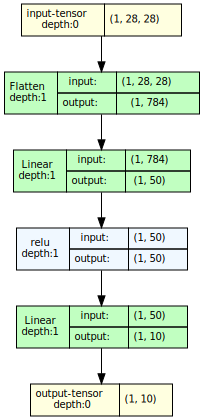

In [45]:
# graphical representation of the model architecture
model_graph = draw_graph(model, input_size=(1, 28, 28), expand_nested=True)
model_graph.visual_graph

##### Train the model - loss and Optimizer

```md
| Function      | What does it do?                                                                                                            |
|---------------|-----------------------------------------------------------------------------------------------------------------------------|
| Loss function | Measures how wrong your models predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better. |
| Optimizer     | Tells your model how to update its internal parameters to best lower the loss.                                              |
```

In [46]:
# Init loss function - common options are nn.CrossEntropyLoss,nn.BCELoss,nn.BCEWithLogitsLoss
loss_fn = nn.CrossEntropyLoss()

# Init optimizers- common options are Adam, SGD ,RMSprop
optimizer = torch.optim.SGD(model.parameters(), lr)

# defining a custom metric - later we will use torch metrics
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

##### Training steps - Design for the training module
```md
| Number | Step name                               | What does it do?                                                                                                                                                                      | Code example                     |
|--------|-----------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------|
| 1      | Forward pass                            | The model goes through all of the training data once, performing its forward() function calculations.                                                                                 | model(x_train)                   |
| 2      | Calculate the loss                      | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.                                                                           | loss = loss_fn(y_pred, y_train)  |
| 3      | Zero gradients                          | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.                                                | optimizer.zero_grad()            |
| 4      | Perform backpropagation on the loss     | Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards". | loss.backward()                  |
| 5      | Update the optimizer (gradient descent) | Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them.                                                                            | optimizer.step()                 |
```

In [47]:
def train_loop(model, dataloader, loss_fn, optimizer):
  """Training loop"""
  train_size = len(dataloader.dataset)
  batch_cnt , batch_loss, batch_acc = 0, 0, 0
  model.train()
  for batch, (X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)
    # model predictions in logits
    pred_logits = model(X)
    # loss calculation
    loss = loss_fn(pred_logits, y)
    # metric calculation
    pred_probs = F.softmax(pred_logits, dim=1)
    pred_classes = pred_probs.argmax(dim=1)
    acc = accuracy_fn(y, pred_classes)

    # backpropagation -> backprop -> optimize -> remove existing gradient
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    batch_loss += loss.item()
    batch_acc += acc
    batch_cnt += 1
    # print the loss and accuracy for predefiend set of batched under one epoch
    if batch % batch_size == 0:
      loss, current = loss.item(), (batch+1) * len(X)
      print(f"loss: {loss:>7f} and Accuracy : {acc:>5f}[{current:>5d}/{train_size:>5d}]")

  batch_loss /= batch_cnt
  batch_acc /= batch_cnt
  print(f"Train Avg metrics: \n Accuracy: {(batch_acc):>0.1f}%, Avg loss: {batch_loss:>8f} \n")
  return batch_loss, batch_acc

##### validation steps - Design for the validation module
1. Declare placeholders for loss and accuracy
2. Init the model in eval mode
3. with no grad calculation context for each batch calculate loss and accuracy
4. Print the loss and accuracy by averaging over all batches

In [48]:
def test_loop(model, dataloader, loss_fn):
  """Testing loop"""
  test_size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval() # putting the model in evaluation mode
  test_loss, test_acc = 0, 0
  with torch.no_grad(): # Context-manager that disables gradient calculation.
    for X,y in dataloader:
      X,y = X.to(device), y.to(device)
      pred_logits = model(X)
      # for each batches cal loss and accuracy and storing them
      test_loss += loss_fn(pred_logits, y).item()
      pred_probs = F.softmax(pred_logits, dim=1)
      pred_classes = pred_probs.argmax(dim=1)
      test_acc += accuracy_fn(y, pred_classes)

  test_loss /= num_batches
  test_acc /= num_batches
  print(f"Test Error: \n Accuracy: {(test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss, test_acc

##### epoch level iterations and loss tracking

In [49]:
train_loss_values = []
test_loss_values = []
epoch_count = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss , train_acc = train_loop(model = model , dataloader=train_loader, loss_fn=loss_fn , optimizer=optimizer)
    test_loss , test_acc = test_loop(model = model , dataloader=test_loader, loss_fn=loss_fn)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)
    epoch_count.append(t)

Epoch 1
-------------------------------
loss: 2.309293 and Accuracy : 13.281250[  128/60000]
loss: 2.265450 and Accuracy : 20.312500[16512/60000]
loss: 2.246453 and Accuracy : 22.656250[32896/60000]
loss: 2.247676 and Accuracy : 38.281250[49280/60000]
Train Avg metrics: 
 Accuracy: 26.4%, Avg loss: 2.261164 

Test Error: 
 Accuracy: 44.1%, Avg loss: 2.216359 

Epoch 2
-------------------------------
loss: 2.206929 and Accuracy : 53.125000[  128/60000]
loss: 2.190484 and Accuracy : 50.781250[16512/60000]
loss: 2.171228 and Accuracy : 57.812500[32896/60000]
loss: 2.112124 and Accuracy : 57.031250[49280/60000]
Train Avg metrics: 
 Accuracy: 51.3%, Avg loss: 2.176455 

Test Error: 
 Accuracy: 56.8%, Avg loss: 2.124698 

Epoch 3
-------------------------------
loss: 2.120186 and Accuracy : 63.281250[  128/60000]
loss: 2.098677 and Accuracy : 61.718750[16512/60000]
loss: 2.053047 and Accuracy : 64.062500[32896/60000]
loss: 2.042555 and Accuracy : 63.281250[49280/60000]
Train Avg metrics: 
 A

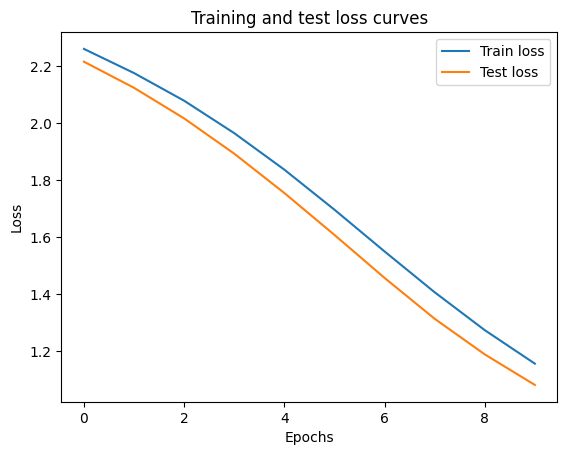

In [50]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

##### Saving and loading a PyTorch model